In [1]:
from selenium import webdriver
import time
import random
from bs4 import BeautifulSoup
import re
from datetime import datetime
import pandas as pd
import seaborn as sns
import os

## 검색결과 불러오기

In [6]:
def load_crwal_datas(fname):
    cpath = ""
    for p in fname:
        if ord(p) <= 255:
            cpath += p
    datas = pd.read_csv(cpath)
    return datas


In [7]:
fname = './data/검색결과_아리따움_3000_12131056.csv'
datas = load_crwal_datas(fname)

In [3]:
def load_crwal_datas(fname):
import os
fname = './data/검색결과_아리따움_3000_12131056.csv'

cpath = ""
for p in fname:
    if ord(p) <= 255:
        cpath += p

# os.rename(fname, cpath)
datas = pd.read_csv(cpath)

# datas = pd.read_csv(fname)

In [4]:
print(len(datas))

2999


In [12]:
datas.head()

,writer,article,likes,replys_count,replys,datetime,img,tags
0,totokodeog_motd,오늘의 립-#아리따움 #젤리바 #멜팅슈#토니모리 #립톤겟잇틴트 #레드핫#넘버7 #하...,4310,8,"(1, 'themonthapril', '@aoibhok'), (2, 'discoso...",2017-12-09 13:04,https://scontent-icn1-1.cdninstagram.com/t51.2...,"'#아리따움', '#젤리바', '#멜팅슈', '#토니모리', '#립톤겟잇틴트', '..."
1,aritaum_official,[로맨틱 홀리데이_LET IT SNOW]아직도 겨울네일 뭐할지 고민중이시라구요?-차...,537,1,'0',2017-12-13 01:34,https://scontent-icn1-1.cdninstagram.com/t51.2...,"'#크리스마스네일', '#연말네일', '#고요한밤', '#로맨틱홀리데이', '#셀프..."
2,fascinate_s,호잇 새로운 아이메이크업영상이!!원브랜드꿀조합 담아봤으니 불토! 불일!에 도전해봐요...,526402,55,"(1, 'youngju42835', '영상 올라오자마자 바로 봣습니당~'), (2,...",2017-12-01 10:40,https://scontent-icn1-1.cdninstagram.com/t51.2...,"'#뷰티유튜버', '#아리따움', '#색조합', '#아이메이크업', '#eyemak..."
3,hanyulofficial,"입술이 갈라지기 쉬운 겨울,#자연감성 으로 향기롭고 촉촉하게 케어하세요. #자연을닮...",370,2,"(1, 'ilovenail.wonju', '잘 보고 갑니다✌'), (2, 'stto...",2017-12-12 02:34,https://scontent-icn1-1.cdninstagram.com/t51.2...,"'#자연감성', '#자연을닮은립밤_', '#한율립밤', '#한율자연템', '#립밤'..."
4,betweendots,Do you wait for your Black Friday and pre-Blac...,202,11,"(1, 'properrosy', 'I still have like 4 to come...",2017-12-12 19:33,https://scontent-icn1-1.cdninstagram.com/t51.2...,"'#aritaum', '#kbeauty', '#abcommunity', '#rasi..."


In [6]:
# likes의 dtypes 가 int 가 아닐 경우
datas['likes'].fillna(0)

0         4310
1          537
2       526402
3          370
4          202
5         1909
6          677
7          167
8          689
9           18
10           3
11          26
12          10
13          39
14          35
15          13
16         230
17          15
18          31
19          37
20          18
21           1
22          16
23          34
24          33
25           4
26          33
27          42
28          30
29          18
         ...  
2969        80
2970       179
2971        32
2972        59
2973       195
2974       147
2975        29
2976        42
2977        34
2978        11
2979        54
2980        29
2981        11
2982       303
2983       362
2984        49
2985       100
2986        38
2987        55
2988        38
2989       145
2990        11
2991        24
2992        11
2993        18
2994       130
2995        17
2996        13
2997         3
2998         6
Name: likes, dtype: int64

In [5]:
datas.dtypes

writer          object
article         object
likes            int64
replys_count     int64
replys          object
datetime        object
img             object
tags            object
dtype: object

# 분석하기

### 시계열 분석하기

In [7]:
def insta_trends_analyser(datas):
    # datas: insta 크롤 결과 pandas 자료형 형태
    datas['day'] = [date[:10] for date in datas['datetime']]    # #월/일 값만 추가  2017-11-25형태
    
    trends = pd.DataFrame()
    trends['article'] = datas.groupby(datas['day'])['article'].count()  #  일자별 인스타 포스팅수
    trends['replies'] = datas.groupby(datas['day'])['replys_count'].sum() # 일자별 댓글 작성수
    trends['likes'] = datas.groupby(datas['day'])['likes'].sum()     # 일자별 좋아요 수
    trends['sum'] = trends.replies + trends.article + trends.likes
    
    return trends

In [8]:
insta_trends = insta_trends_analyser(datas)

In [15]:
insta_trends.head()

,article,replies,likes,sum
day,,,,
2017-11-10,12,28,471,511
2017-11-11,42,247,3456,3745
2017-11-12,53,385,6357,6795
2017-11-13,49,268,3092,3409
2017-11-14,45,291,4752,5088


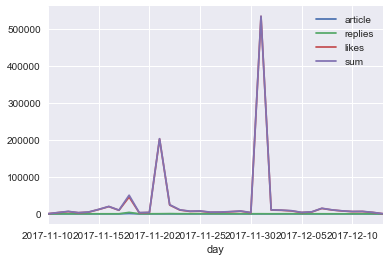

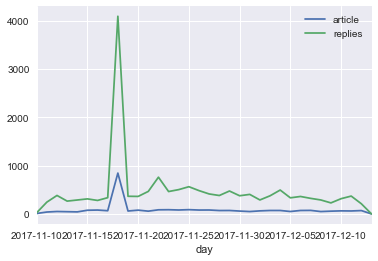

In [9]:
%matplotlib inline
# trends.plot(y = ['article','replys','sum'], ylim=(0,trends['sum'].max()))
insta_trends.plot(y = ['article','replies','likes','sum'])
insta_trends.plot(y = ['article','replies'])

### 태그 분석하기: 빈도수

In [10]:
# 태그 빈도수 계산하기

from collections import Counter

def tag_counter(tag_lists):
    # 인스타 태그 수집결과를 입력하면, 태그 빈도수 카운트가 높은 순으로 보여줌  
    # tag_lists = ["'#라인1태그1'",    "'라인2태그1', '라인2태그2', '라인2태그3'" ] 형식
    
    tag_counts = Counter()
    for tags in tag_lists:
        try: tag_counts.update(tags.replace("'",'').replace(' ','').strip().split(','),)
        except: continue
    tag_counts = tag_counts.most_common()  # 정열하기
    
    return tag_counts

In [11]:
# 상위 태그 그림그리기

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns

def tag_counts_chart(tag_counts, n):
    # matplotlib 한글 사용하기
    font_location = 'c:/Windows/fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=font_location).get_name()
    rc('font',family=font_name)
    
    labels, values = [],[]
    for tags in reversed(tag_counts[:n]):   # 가로 그래프일 경우에는 reversed 로 순서 변경해준다
        label, value = tags
        labels.append(label)
        values.append(value)

    indexes = np.arange(len(labels))
    width = 0.9
    fig = plt.figure(figsize = (8,6))
    plt.barh(indexes, values, width)  # 수평 바 그래프
#     plt.yticks(indexes + width * 0.5, labels, rotation='0')
    plt.yticks(indexes, labels, rotation='0')

    # 세로그래프일 경우
    # plt.bar(indexes, values, width)
    # plt.xticks(indexes + width * 0.5, labels, rotation='90') 
    plt.show()

### tag분석: 워드클라우드

In [13]:
# STOPWORD 제외
def tag_counts_sellector(tag_counts, STOP):
    # STOP 단어를 제외하여  리스트 형태로 출력함(카운터 --> 리스트 형태 변경됨)
    tag_counts_e = []
    for word, count in tag_counts:
        if word not in STOP:
            tag_counts_e.append((word,count))
    return tag_counts_e

In [14]:
# 워드클라우드 그리기

%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def tag_wordcloud(tag_counts, word_num):
    tmp = dict(tag_counts[:word_num])
    wordcloud=WordCloud(font_path="c:/Windows/Fonts/malgun.ttf", relative_scaling=0.5, 
                        background_color="white", max_words=100).generate_from_frequencies(tmp)    #font_step=5
    plt.figure(figsize=(8,6))
    plt.imshow(wordcloud)
    plt.axis('off')

In [15]:
# 태그 빈도 분석1: 집계

tag_lists = datas['tags'].tolist() # 인스타 크롤링 결과 중 태그를 가져온다
tag_counts = tag_counter(tag_lists)  # 태그 카운트 집계한다
# tag_counts_chart(tag_counts, 20)    # 시각화1) 상위 태그 그래프로 확인함

for i,tag_count in enumerate(tag_counts[:30]):
    if i%5 ==0 : print('')
    print(tag_count[0], end=('/'))



#아리따움/#코덕/#뷰티스타그램/#화장품/#에뛰드하우스/
#일상/#메이크업/#맥/#이니스프리/#makeup/
#aritaum/#motd/#뷰티/#미샤/#라네즈/
#코덕스타그램/#에뛰드/#cosmetics/#데일리/#더페이스샵/
#daily/#선팔/#어퓨/#뷰스타그램/#코스메틱/
#맞팔/#틴트/#마몽드/#소통/#모노아이즈/

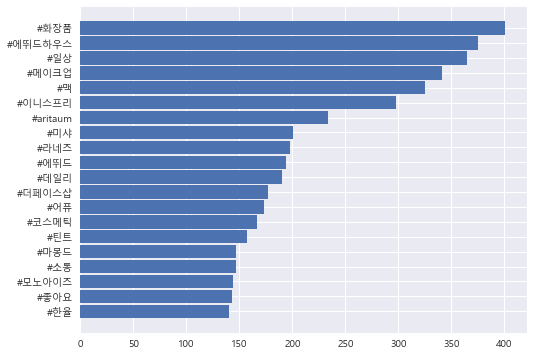

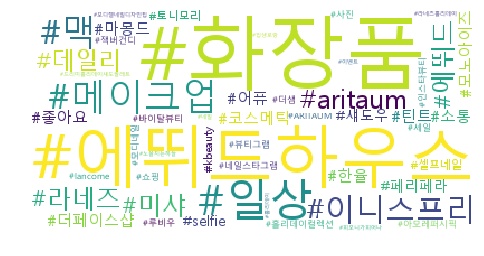

In [16]:
# 태그 빈도 분석2: 정리하기
STOP = ['#코덕', '#뷰티스타그램', '#코덕스타그램', '#뷰스타그램', '#motd', '#eotd', '#makeupoftheday', '#맞팔', 
        '#선팔', '#화장품스타그램', '#팔로우', '#오늘의화장', '#오늘의메이크업', '#일상스타그램', '#makeupoftheday', 
        '#선팔환영🙌', '#아리따움', '#beauty', '#뷰티', '#cosmetics','#makeup', '#今日のメイク', '#daily', '#makeup',
       '#뷰티', '#셀스타그램', '#쇼핑스타그램','#MOTD', '#하늘아래같은색조는없다' ]

tag_counts_selected = tag_counts_sellector(tag_counts, STOP)    # 불용어 데이터 확인한다
tag_counts_chart(tag_counts_selected, 20)    # 시각화1) 상위 태그 그래프로 확인함
tag_wordcloud(tag_counts_selected,50)        # 시각화2) 워드클라우드 그리기

## 2) SNA

In [17]:
# 단어 관계 행렬 쓰기 
from collections import Counter
from itertools import combinations


In [75]:
# 게시글별 태그리스트 정리한다

def tag_lists_selector(tag_lists, STOP=[]):
    # 인스타 태그 검색결과 중 일부
    
    tag_lists_sel = []
    for tags in tag_lists:
        tag_sel = tags.replace("'",'').replace(' ','').split(',')
        tag_lists_sel.append([tag for tag in tag_sel if tag not in STOP])
    return tag_lists_sel
  

In [19]:
# 단어 관계 행렬 쓰기 
from collections import Counter
from itertools import combinations


def word_matrix(tag_lists, stop=None, must=None):
    # 매트릭스 만들기
    word_cooc_mat=Counter()
    for line in tag_lists:
        for word1, word2 in combinations(line,2):
            if stop!=None and (word1 in stop or word2 in stop): continue
            if must!=None and (word1 not in must and word2 not in must): continue
            if word1 == word2: continue  #동일한 단어간의 벡터는 계산하지 않음
            elif word_cooc_mat[(word2,word1)]>=1:word_cooc_mat[(word2,word1)]+=1
            else: word_cooc_mat[(word1,word2)]+=1    
    
    word_coocs = []
    for words, count in word_cooc_mat.items():
        word_coocs.append((words[0],words[1],count))
    
    sorted_word_coocs = sorted(word_coocs, key=lambda x: x[2], reverse=True)   # 정렬하기
    
    return sorted_word_coocs

In [82]:
#그래프 그리기
import networkx as nx
import matplotlib.pyplot as plt
import sys

def word_sna_graph(word_matrix, n, fname=None):
    G= nx.Graph()
    for word1, word2, count in word_matrix[:n]:    #상위 n개로만 그림 그리기
        G.add_edge(word1, word2, weight=count)
    T = nx.minimum_spanning_tree(G)
    nodes = nx.nodes(T)
    degrees = nx.degree(T)
    node_size = []

    for node in nodes:
        ns = degrees[node]*200
        node_size.append(ns)

    if sys.platform in ["win32", "win64"]: font_name = "malgun gothic"
    elif sys.platform == "darwin": fornt_name = "AppleGothic"
    plt.figure(figsize=(12,10))    
    nx.draw(T,
           pos=nx.fruchterman_reingold_layout(G, k=0.5),
           node_size=node_size,
           node_color="#42FC0A",   #노란색: "#FFE27F"
            # http://www.colourlovers.com/palettes/add  에서 색상 가져올 수 있음
           font_family=font_name,
           label_pos=0, #0=head, 0.5=center, 1=tail
            with_labels=True,
            font_size=10 )
    if fname!=None: 
        plt.savefig(fname)
        print('{}에 저장하였습니다'.format(fname))
    plt.axis("off")

    plt.show()    

In [21]:

STOP = ['#코덕', '#뷰티스타그램', '#코덕스타그램', '#뷰스타그램', '#motd', '#eotd', '#makeupoftheday', '#맞팔', 
        '#선팔', '#화장품스타그램', '#팔로우', '#오늘의화장', '#오늘의메이크업', '#일상스타그램', '#makeupoftheday', 
        '#선팔환영🙌', '#아리따움', '#beauty', '#뷰티', '#cosmetics','#makeup', '#今日のメイク', '#daily', '#makeup',
       '#aritaum', '#뷰티', '#ARITAUM', '#셀스타그램']
print(STOP)

['#코덕', '#뷰티스타그램', '#코덕스타그램', '#뷰스타그램', '#motd', '#eotd', '#makeupoftheday', '#맞팔', '#선팔', '#화장품스타그램', '#팔로우', '#오늘의화장', '#오늘의메이크업', '#일상스타그램', '#makeupoftheday', '#선팔환영🙌', '#아리따움', '#beauty', '#뷰티', '#cosmetics', '#makeup', '#今日のメイク', '#daily', '#makeup', '#aritaum', '#뷰티', '#ARITAUM', '#셀스타그램']


In [62]:
# tag 빈도수 점검(STOP 제외)
for i,tag_count in enumerate(tag_counts[100:200]):
    if i%5 ==0 : print('')
    if tag_count[0] not in STOP: print(tag_count[0], end=('/'))


#립스틱/#라네즈홀리데이파티/#라네즈홀리데이투톤립바/#라네즈홀리데이쿠션블러셔/#선팔맞팔환영/
#photo/#korea/#데일리뉴트리션/#化粧品/#파우더룸이벤트/
#파우더룸체험단/#아이폰/#love/#바디로션/#일리윤/
#beautiful/#미스트/#어린쑥/#카노아이/#eyemakeupoftheday/
#powderroom/#일리윤세라마이드아토로션/#라네즈더블레이어링오일/#에뛰드순정/#기초제품/
#나나지름/#아이오페/#붙이는젤네일/#쇼핑스타그램/#틴트인워터/
#black/#화장/#make/#한정섀도팔레트/#마카롱/
#아이메이크업/#품위있는그녀/#hot/#star/#섬총사🏝/
#金喜善/#kimheeseon/#힌지엔터테인먼트/#princess/#game/
#lovely/#Style/#movie/#sexy/#onepiece/
#rose/#apple/#홀리카홀리카/#MOTD/#ティント/
#익산/#모디/#今日のリップ/#リップ/#ランコム/
#ジューシーシェイカー/#juicyshaker/#일산/#웨스턴돔/#라페스타/
#소통돈쓰기😘/#진정수/#아리따움모현배산점/#코덕맞팔/#한정판/
#눈화장/#스킨푸드/#유니크/#eyemakeup/#화장품추천/
#HANYUL/#데일리메이크업/#셀피/#선팔하면맞팔/#발색/
#올리브영/#좋아요반사/#섀도우팔레트/#tour/#uniquemagic/
#유니콘메이업/#유니콘매직컬렉션/#자연주의/#나스/#고1/
#레이디얼그레이/#171118/#프로스트윙크드/#인스타그램/#새틴토프/
#웨딩베일/#배드갤래쉬/#추천/#event/#겨울/

In [9]:
STOP = ['#코덕', '#뷰티스타그램', '#코덕스타그램', '#뷰스타그램', '#motd', '#eotd', '#makeupoftheday', '#맞팔', 
        '#선팔', '#화장품스타그램', '#팔로우', '#오늘의화장', '#오늘의메이크업', '#일상스타그램', '#makeupoftheday', 
        '#선팔환영🙌', '#아리따움', '#beauty', '#뷰티', '#cosmetics','#makeup', '#今日のメイク', '#daily', '#makeup',
       '#뷰티', '#셀스타그램', '#쇼핑스타그램','#MOTD', '#하늘아래같은색조는없다' ]
# must = ['#강아지습진', '#강아지샴푸','#강아지비누']

must = None

tags_raw = datas['tags'].dropna().tolist() # 인스타 크롤링 결과 중 태그를 가져온다
tag_lists = tag_lists_selector(tags_raw)
word_cooc = word_matrix(tag_lists, stop=STOP, must=must)
print(word_cooc[:20])

fname = './data/아리따움v4'
word_sna_graph(word_cooc,70,fname) #저장할경우

# word_sna_graph(word_cooc,200)


NameError: name 'tag_lists_selector' is not defined

In [40]:
# 특정단어 트랜드 분석

In [25]:
def insta_trends_word(datas, word):
    datas['day'] = [date[:10] for date in datas['datetime']]    # #월/일 값만 추가  2017-11-25형태
    check = [word in str(tags) for tags in datas.tags]

    trends = pd.DataFrame()
    trends['article'] = datas[check].groupby(datas['day'])['article'].count()  #  일자별 인스타 포스팅수
    trends['replies'] = datas[check].groupby(datas['day'])['replys_count'].sum() # 일자별 댓글 작성수
    trends['likes'] = datas[check].groupby(datas['day'])['likes'].sum()     # 일자별 좋아요 수
    trends['sum'] = trends.replies + trends.article + trends.likes
    
    return trends

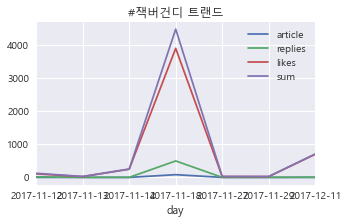

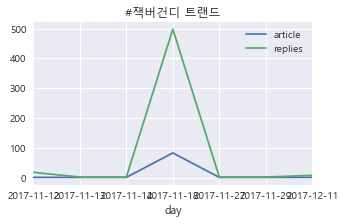

In [70]:
WORD = '#잭버건디'
word_trends = insta_trends_word(datas, WORD)
word_trends.plot(y = ['article','replies','likes','sum'], title = '{} 트랜드'.format(WORD), figsize=(5,3))
word_trends.plot(y = ['article','replies'], title = '{} 트랜드'.format(WORD),figsize=(5,3))

### 워드 임베딩

In [26]:
#워드임베딩 모델 생성하기
import gensim
from gensim.models import Word2Vec


In [8]:
#워드투백 모델 생성하기
def make_word2vec(tags_raw, STOP=[]):
    tag_lists_selected = tag_lists_selector(tags_raw, STOP=STOP)  #stop 제외한 태그리스트
    model = Word2Vec(tag_lists_selected, size=100, window=10, min_count=5)
    return model

model = make_word2vec(tags_raw, STOP=STOP)

NameError: name 'tags_raw' is not defined

In [62]:
#유사단어 찾기 함수
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns

def word2vec_similar(model, word, topn=20):
    # matplotlib 한글 사용하기
    font_location = 'c:/Windows/fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=font_location).get_name()
    rc('font',family=font_name)
    
    labels, values = [],[]
    for tags in reversed(model.wv.most_similar(word, topn=topn)):   # 가로 그래프일 경우에는 reversed 로 순서 변경해준다
        label, value = tags
        labels.append(label)
        values.append(value)
        
    indexes = np.arange(len(labels))
    width = 0.9
    fig = plt.figure(figsize = (5,4))
    plt.barh(indexes, values, width)  # 수평 바 그래프
    plt.yticks(indexes, labels, rotation='0')
    low = min(values)
    high = max(values)
    plt.xlim([(low-1.5*(high-low)),1])
    plt.title('{}와 함께 사용된 단어 Top{}'.format(word,topn))


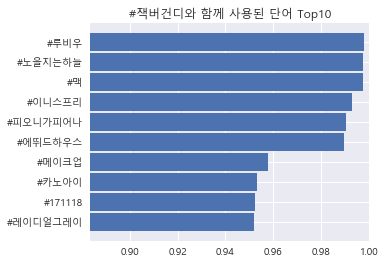

In [86]:
word2vec_similar(model, '#잭버건디', topn=10)

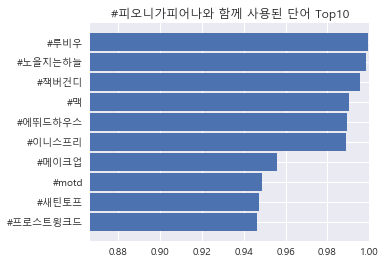

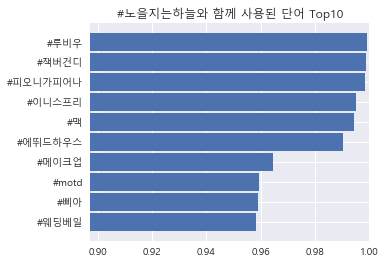

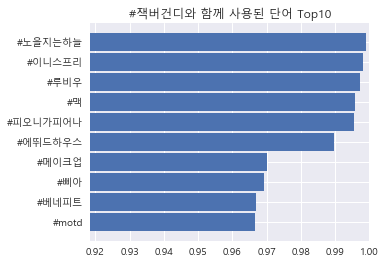

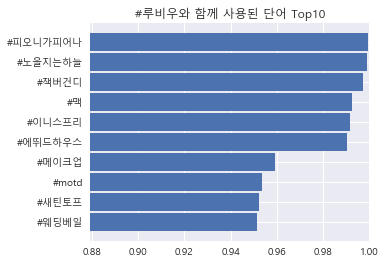

In [68]:
# 유사단어 확인할 단어 선택함
# tag_counts_sellector = tag_counts_sellector(tag_counts, STOP)
# selected_words = tag_counts_selected[:10]
# for tag in selected_words:
#     most_similar(model, tag[0], topn=10)


selected_words = ['#피오니가피어나', '#노을지는하늘','#잭버건디','#루비우']
for word in selected_words:
    word2vec_similar(model, word, topn=10)
